In [1]:
import pandas as pd
import torch
from kan import *

In [ ]:
df = pd.read_csv('solvents_properties.csv')
df

In [2]:
torch.set_default_dtype(torch.float32)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [3]:
from kan.utils import create_dataset
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)
dataset['train_input'].shape, dataset['train_label'].shape, dataset['test_input'].shape, dataset['test_label'].shape, 

(torch.Size([1000, 2]),
 torch.Size([1000, 1]),
 torch.Size([1000, 2]),
 torch.Size([1000, 1]))

In [ ]:
X = torch.tensor(df[['δd', 'δp', 'δh']].values.astype('float32')).to(device)
y = torch.tensor(df['δT'].values.astype('float32')).to(device)

checkpoint directory created: ./model
saving model version 0.0


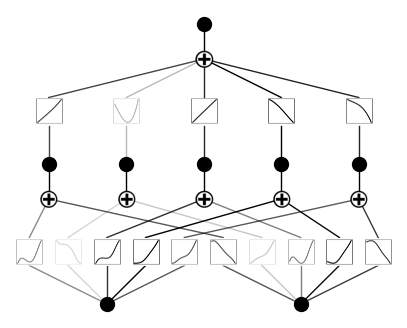

In [6]:
# create a KAN: 3D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=3, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot()

In [ ]:
from sklearn.model_selection import train_test_split

def generate_kan_dataset(X, y):
    """
    Generate dataset for kan.

    Args:
        X(nparray): tensor of train_input.
        y(nparray): tensor of train_label.
    Returns:
        dict: A dictionary containing train_input, train_label, test_input, test_label
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    dataset = {'train_input': [], 'test_input': [], 'train_label': [], 'test_label': []}

    # Convert lists to tensors
    dataset['train_input'] = torch.tensor(X_train)
    dataset['test_input'] = torch.tensor(X_test)
    dataset['train_label'] = torch.tensor(y_train).reshape(-1, 1)
    dataset['test_label'] = torch.tensor(y_test).reshape(-1, 1)

    return dataset

In [ ]:
dataset = generate_kan_dataset(X, y)
dataset

In [ ]:
def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

In [8]:
# train the model
result = model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001) #metrics=(train_acc, test_acc)

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]/Users/lpc_0066/anaconda3/envs/kan/lib/python3.12/site-packages/kan/spline.py:121: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  coef = (A.pinverse() @ B)[:,:,:,0]
| train_loss: 1.60e-02 | test_loss: 1.65e-02 | reg: 7.16e+00 | : 100%|█| 50/50 [00:36<00:00,  1.36it

saving model version 0.1


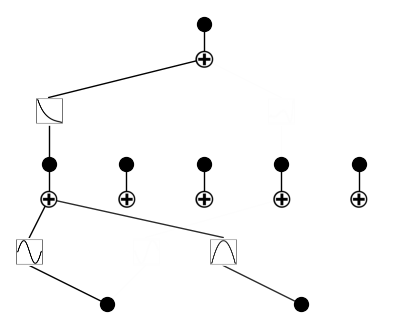

In [9]:
model.plot()

saving model version 0.2


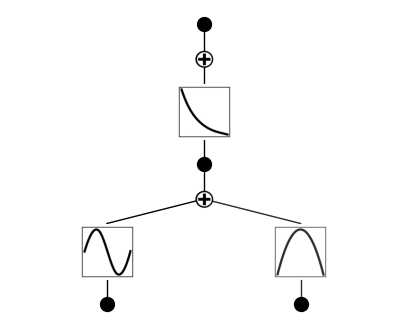

In [10]:
model = model.prune()
model.plot()

In [ ]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001, metrics=(train_acc, test_acc))

In [ ]:
model = model.refine(10)

In [ ]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001, metrics=(train_acc, test_acc))

In [ ]:
model = model.prune()

In [ ]:
model.plot()

In [ ]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']

model.auto_symbolic(lib=lib)

In [ ]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001, metrics=(train_acc, test_acc))

In [ ]:
from kan.utils import ex_round

result = ex_round(model.symbolic_formula()[0][0], 4)
result

In [ ]:
import math

# Given values
x1 = 15.8
x2 = 8.8
x3 = 9.4

# Calculate the result of the equation
result = (
    0.7931 * x1
    + 0.3564 * x2
    + 0.3495 * x3
    + 0.4249 * math.sin(1.2026 * x1 - 0.7399 * x2 + 1.3698 * x3 + 3.2397)
    + 1.8047
)

result
